# 0: Task and Tools

The goal is to code the rotation of an image by 30 degrees using a rotation matrix.

We'll use _PIL_ for importing images, _math_ for sin/cos, _numpy_ for linear algebra, and _imshow_ to display our images in the notebook.

In [1]:
from PIL import Image
import math
import numpy as np
from matplotlib.pyplot import imshow

# 1: Transforming our image (rgb tensor) to cartesian coordinates mapped to rgb values.

First we load in our image:

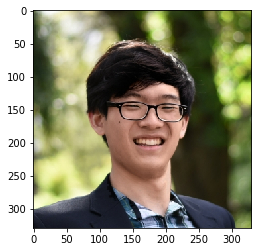

In [2]:
%matplotlib inline
original = Image.open('aj_face.jpeg')
image_tensor = np.asarray(original)
imshow(image_tensor)

As we can see below, the image loads as a numpy ndarray with 329 rows, 330 columns, and 3 depths. That's 329 in _width_, 330 pixels in _height_, and 3 rgb values in _Depth_. At this point, the coordinate information for each rgb is stored implicitly. We want to extract the coordinates explicitly so we can perform a rotation upon each.

In [3]:
type(image_tensor), image_tensor.shape, image_tensor.dtype

(numpy.ndarray, (329, 330, 3), dtype('uint8'))

To do this, I'm going to flatten our numpy array, so that it's a long list of aggregated rgb values. That way I can attach coordinates to each later.

In [4]:
w = image_tensor.shape[0]
h = image_tensor.shape[1]
D = image_tensor.shape[2] # D is capital to indicate it as a constant. we won't be modifying D

flattened_pixels = image_tensor.reshape((w * h, D)) # directly from np.array(im.getdata()) also works
flattened_pixels, flattened_pixels.shape, flattened_pixels.dtype

(array([[ 87,  90,  59],
        [ 93,  98,  66],
        [100, 105,  73],
        ..., 
        [146, 165,  83],
        [144, 166,  83],
        [144, 166,  84]], dtype=uint8), (108570, 3), dtype('uint8'))

To attach the coordinates correctly, let's make sure we understand how the reshaping works. From the original tensor of rgb values, we'll select the first 5 rgb groups along the y axis at the first x. By comparing to the flattened output above, we know the flattening goes by columns.

In [5]:
image_tensor[0,:5,:]

array([[ 87,  90,  59],
       [ 93,  98,  66],
       [100, 105,  73],
       [115, 122,  91],
       [131, 140, 109]], dtype=uint8)

Now that we know the order in which the pixels flattened, we can appropriately map each pixel's coordinate as a vector to its rgb value.  We also translate our coordinates so that the origin is at the center of the image.

In [6]:
# create a bunch of x,y vectors
dx = int(w/2)
dy = int(h/2)
coordinate_generator = (np.array([x - dx, y - dy]) for x in range(w) for y in range(h))
coordinates_and_rgb = list(zip(coordinate_generator, flattened_pixels)) # take out the list later
print('Transformed output, formatted (coordinate, rgb):')
coordinates_and_rgb[:5]

Transformed output, formatted (coordinate, rgb):


[(array([-164, -165]), array([87, 90, 59], dtype=uint8)),
 (array([-164, -164]), array([93, 98, 66], dtype=uint8)),
 (array([-164, -163]), array([100, 105,  73], dtype=uint8)),
 (array([-164, -162]), array([115, 122,  91], dtype=uint8)),
 (array([-164, -161]), array([131, 140, 109], dtype=uint8))]

Before going further, I'll write a function to transform our mapped data structure back to the original, so we know it works as intended.

In [7]:
def points_to_tensor(points, shape):
    tensor = np.zeros(shape, np.uint8)
    dx = shape[0] / 2
    dy = shape[1] / 2
    for point in points:
        (x, y), rgb = point # might be something wonky with row/col
        # add back half the width and height to center the image
        x, y = int(x + dx), int(y + dy)
        tensor[x][y] = rgb
        #print(f'Row: {row}. Col: {col}')
    return tensor

Original shape: (329, 330, 3). Return shape: (329, 330, 3)
Original first 5:
[[ 87  90  59]
 [ 93  98  66]
 [100 105  73]
 [115 122  91]
 [131 140 109]] 
Return first 5:
[[ 87  90  59]
 [ 93  98  66]
 [100 105  73]
 [115 122  91]
 [131 140 109]]


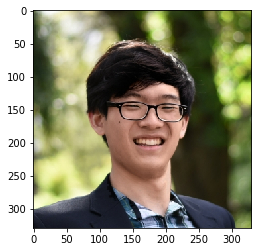

In [8]:
should_go_back = points_to_tensor(coordinates_and_rgb, image_tensor.shape)
print(f'Original shape: {image_tensor.shape}. Return shape: {should_go_back.shape}')
print(f'Original first 5:\n{image_tensor[0,:5,:]} \nReturn first 5:\n{should_go_back[0,:5,:]}')
imshow(Image.fromarray(should_go_back, 'RGB'))

Great! We get back the original. Now we can start rotating points.

# 2: Applying the rotation

First we need to define a function to get a rotation matrix for a specified angle. 

In [9]:
def make_rotation_matrix(degree):
    " Return a rotation matrix that rotates by the given angle in degrees "
    theta = math.radians(degree)
    return np.array([
        [math.cos(theta), math.sin(theta)],
        [-math.sin(theta), math.cos(theta)]
    ])

Let's test this by creating a rotation matrix for 30 degrees counterclockwise. Note the display in array form is transposed from standard matrix form. Looks good!

In [10]:
# make sure rotation 30 degrees is accurate
rotate_30_test = make_rotation_matrix(30)
rotate_30_test # we won't use this variable again

array([[ 0.8660254,  0.5      ],
       [-0.5      ,  0.8660254]])

Now we can apply the matrix transformation to each of the coordinates.

In [11]:
def rotate_func(degrees):
    """ 
    Returns a rotation function that can be used with map.
    """
    rotation_matrix = make_rotation_matrix(degrees)
    def rotate(point):
        "Applies the rotation transformation"
        location, rgb = point
        new_location = rotation_matrix.dot(location)
        return (new_location, rgb)
    return rotate
    

rotated_points = np.array(list(map(rotate_func(30), coordinates_and_rgb)))
rotated_points[:5]

array([[array([-224.52816622,  -60.89419162]),
        array([87, 90, 59], dtype=uint8)],
       [array([-224.02816622,  -60.02816622]),
        array([93, 98, 66], dtype=uint8)],
       [array([-223.52816622,  -59.16214082]),
        array([100, 105,  73], dtype=uint8)],
       [array([-223.02816622,  -58.29611541]),
        array([115, 122,  91], dtype=uint8)],
       [array([-222.52816622,  -57.43009001]),
        array([131, 140, 109], dtype=uint8)]], dtype=object)

Get the min and max x and y values, so we know how big to make the tensor that will hold our rotated points.

In [12]:
min_x = min(rotated_points, key=lambda a: a[0][0]) [0][0] # coordinate, x
max_x = max(rotated_points, key=lambda a: a[0][0]) [0][0] # coordinate, x
min_y = min(rotated_points, key=lambda a: a[0][1]) [0][1] # coordinate, y
max_y = max(rotated_points, key=lambda a: a[0][1]) [0][1] # coordinate, y

rot_width = math.ceil(max_x - min_x)
rot_height = math.ceil(max_y - min_y)
print(f'Width: {rot_width}. Height: {rot_height}')

Width: 449. Height: 449


Our image dimensions grew. That's to be expected, as rotating moves the corners farther up and out.

Iterate through our rotated points, and use their location to place them at the appropriate index in the target tensor.

In [13]:
tilted_image = points_to_tensor(rotated_points, (rot_width, rot_height, D))
tilted_image[:2]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

Make an image from the tensor and see what we get!

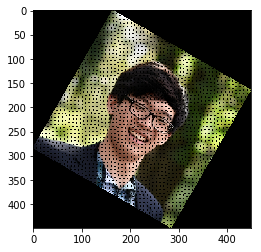

In [14]:
img = Image.fromarray(tilted_image, 'RGB')
img.save('tilted.png')
imshow(img)

Perform a true rotation using a built in function to check.

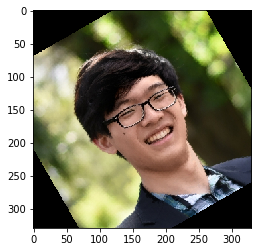

In [15]:
true_rotate = original.rotate(30)
imshow(true_rotate)

Woops, looks like we rotated the wrong way. I'll have to look into that.